In [2]:
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, ConvLSTM2D, MaxPool3D, UpSampling3D
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

2024-02-18 21:15:11.366655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 21:15:12.307512: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/extras/CUPTI/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2024-02-18 21:15:12.307614: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/extras/CUPTI/lib64:

In [3]:
# Load dataset

DATASET_FILE = "../dataset/dataset_small_140224.npy"

dataset_original = np.load(DATASET_FILE)
#################################
dataset_original = dataset_original[:2, ...]
#################################
print(dataset_original.shape)

dataset_original = np.float32(dataset_original)

# Add a channel dimension
dataset_original = np.expand_dims(dataset_original, axis=-1)

# Normalize data
print(np.min(dataset_original), np.max(dataset_original), np.mean(dataset_original), np.median(dataset_original), np.var(dataset_original))
scaler = MinMaxScaler()
dataset_original = scaler.fit_transform(dataset_original.reshape(-1, dataset_original.shape[-1])).reshape(dataset_original.shape)
print(np.min(dataset_original), np.max(dataset_original), np.mean(dataset_original), np.median(dataset_original), np.var(dataset_original))

# print(dataset_original.shape)
NUM_SEQUENCES = dataset_original.shape[0]
LENGHT_SEQUENCE = dataset_original.shape[1]
WIDTH = dataset_original.shape[2]
HEIGHT = dataset_original.shape[3]
# print(NUM_SEQUENCES, LENGHT_SEQUENCE, WIDTH, HEIGHT)

(2, 400, 400, 200)
-1.0 0.10758182 0.009818276 0.042281613 0.036876976
0.0 0.99999994 0.9117284 0.9410425 0.030061018


In [4]:
WINDOW = 5

sliced_dataset = dataset_original.reshape(-1, WINDOW, dataset_original.shape[2], dataset_original.shape[3], 1)
print(sliced_dataset.shape)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(sliced_dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * sliced_dataset.shape[0])]
val_index = indexes[int(0.9 * sliced_dataset.shape[0]) :]
train_dataset = sliced_dataset[train_index]
val_dataset = sliced_dataset[val_index]

print(train_dataset.shape)
print(val_dataset.shape)

X_train, y_train = train_dataset[:,:-1,:,:,:], train_dataset[:,-1:,:,:,:]
X_val, y_val = val_dataset[:,:-1,:,:,:], val_dataset[:,-1:,:,:,:]

print(str(X_train.shape) + ", " + str(y_train.shape))
print(str(X_val.shape) + ", " + str(y_val.shape))


(160, 5, 400, 200, 1)
(144, 5, 400, 200, 1)
(16, 5, 400, 200, 1)
(144, 4, 400, 200, 1), (144, 1, 400, 200, 1)
(16, 4, 400, 200, 1), (16, 1, 400, 200, 1)


In [ ]:
batch_size = 8

GPUS = ["GPU:0","GPU:1"]
strategy = tf.distribute.MirroredStrategy(GPUS)

with strategy.scope():
    input_dimensions = X_train[0].shape

    # Encoder
    input = Input(input_dimensions)
    encoder = ConvLSTM2D(filters=64, kernel_size=(4,4), padding="same",
                        return_sequences=True, activation="relu")(input)
    encoder = MaxPool3D(pool_size=(2,2,2))(encoder)
    encoder = ConvLSTM2D(filters=32, kernel_size=(4,4), padding="same",
                        return_sequences=True, activation="relu")(encoder)
    encoder = MaxPool3D(pool_size=(2,2,2))(encoder)
    encoder = ConvLSTM2D(filters=32, kernel_size=(2,2), padding="same",
                        return_sequences=True, activation="relu", name='encoder_output')(encoder)

    # Decoder 1 (sequence)
    decoder_1 = ConvLSTM2D(filters=32, kernel_size=(2,2), padding="same",
                        return_sequences=True, activation="relu")(encoder)
    decoder_1 = UpSampling3D(size=(2,2,2))(decoder_1)
    decoder_1 = ConvLSTM2D(filters=32, kernel_size=(4,4), padding="same",
                        return_sequences=True, activation="relu")(decoder_1)
    decoder_1 = UpSampling3D(size=(2,2,2))(decoder_1)
    decoder_1 = ConvLSTM2D(filters=64, kernel_size=(4,4), padding="same",
                        return_sequences=True, activation="relu")(decoder_1)
    decoder_1 = Conv2D(filters=1, kernel_size=(4,4), padding="same",
                        activation="relu", name='decoder_1_output')(decoder_1)


    

    # model = Model(inputs=input, outputs=[decoder_1, decoder_2])
    model = Model(inputs=input, outputs=decoder_1)

    model.compile(optimizer='adam', loss='mse')

model.save("./_model.h5", save_format="h5")

# model.summary()

In [ ]:
history = model.fit(
                    # X_train, [X_train, y_train],
                    X_train, X_train, 
                    # validation_data=(X_val, [X_val, y_val]),
                    # validation_data=(X_val, X_val),
                    batch_size=batch_size, epochs=10,
                    verbose=1)

model.save("./_model.h5", save_format="h5")

In [ ]:
plt.plot(history.history['loss'][2:])
plt.title('decoder 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train'], loc='upper left')
plt.show()


# plt.plot(history.history['decoder_1_output_loss'])
# plt.plot(history.history['val_decoder_1_output_loss'])
# plt.title('decoder 1 loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.plot(history.history['decoder_2_output_loss'])
# plt.plot(history.history['val_decoder_2_output_loss'])
# plt.title('decoder 2 loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [5]:
model = load_model("./model.h5")

2024-02-18 21:15:28.122986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 21:15:29.452836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14619 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2024-02-18 21:15:29.454112: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14619 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:5e:00.0, compute capability: 7.0


In [ ]:
results = model.evaluate(X_val, X_val)
print(results)

In [ ]:
# Visualize Encoder-Decoder
example = X_train[100].copy()
print(example.shape)
print(np.min(example), np.max(example), np.mean(example), np.median(example), np.var(example))

new_prediction = model.predict(np.expand_dims(example, axis=0), verbose=0)[0]
print(new_prediction.shape)
print(np.min(new_prediction), np.max(new_prediction), np.mean(new_prediction), np.median(new_prediction), np.var(new_prediction))

color_map = plt.cm.jet
# color_map.set_bad(color='black')

example[example==0.0] = np.nan
new_prediction[new_prediction==0.0] = np.nan

color_map = plt.cm.jet
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
for idx, ax in enumerate(axes.flat):
    frame = example[idx]
    ax.imshow(np.squeeze(frame).transpose(), cmap=color_map)
    ax.set_title(f"Sequence {idx + 1}")
    ax.axis("off")


color_map = plt.cm.jet
fig, axes = plt.subplots(1, 4, figsize=(10, 8))
for idx, ax in enumerate(axes.flat):    
    predicted_frame = new_prediction[idx]
    ax.imshow(np.squeeze(predicted_frame).transpose(), cmap=color_map)
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

(400, 200, 1)
0.0 0.9708011 0.9206006 0.9408699 0.021224787
0.0 0.9708011 0.9206006 0.9408699 0.021224787


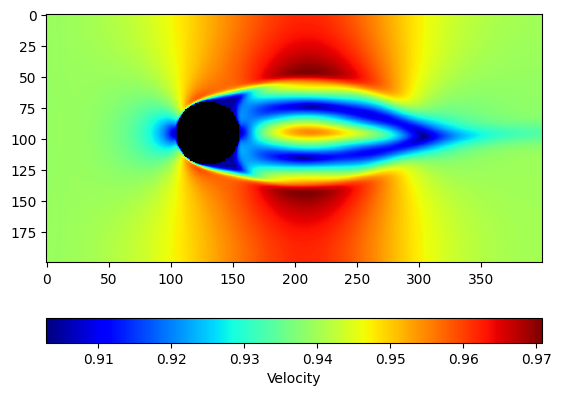

In [6]:
example = X_train[100].copy()
frame = example[0].copy()
print(frame.shape)
print(np.min(frame), np.max(frame), np.mean(frame), np.median(frame), np.var(frame))

print(np.min(frame), np.max(frame), np.mean(frame), np.median(frame), np.var(frame))

color_map = plt.cm.jet
color_map.set_bad(color='black')
frame[frame==0.0] = np.nan

# plt.clf()
plt.imshow(np.squeeze(frame).transpose(), cmap=color_map)
plt.colorbar(label="Velocity", orientation="horizontal")

0.0 0.9708011 0.9206006 0.9408699 0.021224787
0.0 1.0264779 0.92841953 0.9503311 0.021439886
0.9028724 0.9708011 0.9206006 0.9408699 0.021224787
0.022567209 1.0264779 0.92841953 0.9503311 0.021439886


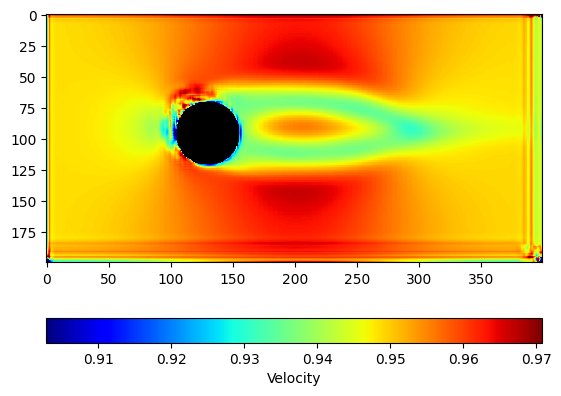

In [16]:
example = X_train[100].copy()
print(np.min(example[0]), np.max(example[0]), np.mean(example[0]), np.median(example[0]), np.var(example[0]))

new_prediction = model.predict(np.expand_dims(example, axis=0), verbose=0)[0]
predicted_frame = new_prediction[0]
# print(predicted_frame.shape)
print(np.min(predicted_frame), np.max(predicted_frame), np.mean(predicted_frame), np.median(predicted_frame), np.var(predicted_frame))


print(np.min(example[0][example[0]!=0]), np.max(example[0]), np.mean(example[0]), np.median(example[0]), np.var(example[0]))
print(np.min(predicted_frame[predicted_frame!=0]), np.max(predicted_frame), np.mean(predicted_frame), np.median(predicted_frame), np.var(predicted_frame))



color_map = plt.cm.jet
color_map.set_bad(color='black')
predicted_frame[predicted_frame==0.0] = np.nan

# predicted_frame[predicted_frame<np.min(example[example!=0])] = np.nan
# predicted_frame[predicted_frame>np.max(example[example<1])] = np.nan

plt.clf()
plt.imshow(np.squeeze(predicted_frame).transpose(), cmap=color_map, vmin=np.min(example[0][example[0]>0]), vmax=np.max(example[0]))
plt.colorbar(label="Velocity", orientation="horizontal")


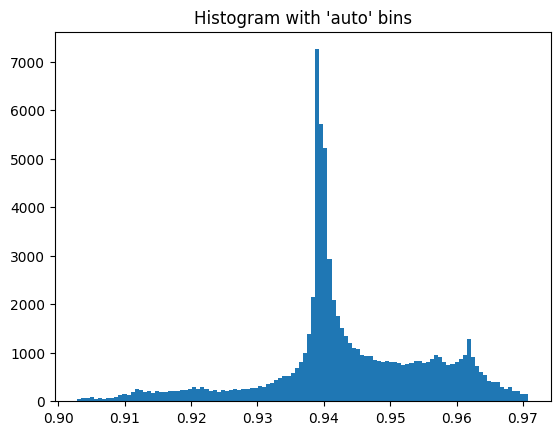

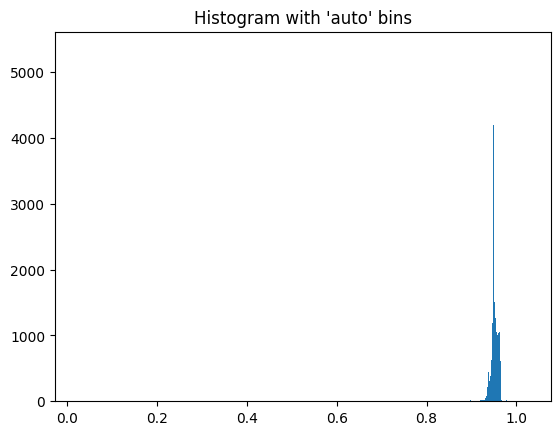

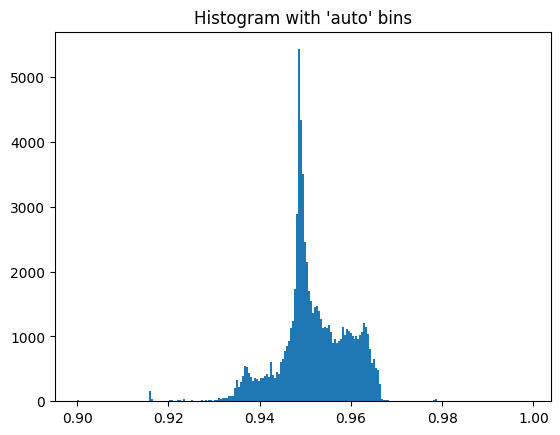

In [17]:
# import sys
# np.set_printoptions(threshold=100000, precision=4, linewidth=1000)
# print(frame.flatten())
# print(predicted_frame.flatten())

plt.clf()
a = np.hstack(frame.flatten())
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

plt.clf()
a = np.hstack(predicted_frame.flatten())
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

predicted_frame[predicted_frame<0.9] = np.nan
predicted_frame[predicted_frame>1] = np.nan

plt.clf()
a = np.hstack(predicted_frame.flatten())
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [ ]:
# a = np.array([[[1,2,3,4],[1,2,3,4],[1,2,3,4]],[[1,-1,-1,4],[1,-1,-1,4],[1,-1,-1,4]],[[1,2,3,4],[1,2,3,4],[1,2,3,4]]])
# b = np.array([[[1.2,2.2,3.2,4],[1.2,2.2,3.2,4.2],[1.2,2.2,3.2,4.2]],[[1.2,0.2,0.2,4.2],[1.2,0.2,0.2,4.2],[1.2,0.2,0.2,4.2]],[[1.2,2.2,3.2,4.2],[1.2,2.2,3.2,4.2],[1.2,2.2,3.2,4.2]]])
# print(a)
# print("////")
# print(b)
# print("////")
# b[a<=0] = -1
# print(b)

In [ ]:
# new_prediction = model.predict(np.expand_dims(example, axis=0), verbose=0)[0]


# frame = new_prediction[0]
# print(frame.shape)
# frame = np.squeeze(frame)
# print(frame.shape)

# color_map.set_bad(color='black')
# frame[frame==0.0] = np.nan

# print(np.max(frame))
# print(np.min(frame))

# color_map.set_bad(color='black')
# frame[frame==-1] = np.nan

# plt.clf()
# plt.imshow(frame.transpose(), cmap=color_map)
# plt.colorbar(label="Velocity", orientation="horizontal")

In [ ]:
# Visualize Encoder-Predict

# example_input = X_val[1000]
# example_output = y_val[1000]
# new_prediction = model.predict(np.expand_dims(example_input, axis=0), verbose=0)[1][0]
# print(example_input.shape)
# print(example_output.shape)
# print(new_prediction.shape)

# fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# # Plot the original frames.
# for idx, ax in enumerate(axes[0]):
#     ax.imshow(np.squeeze(y_val[idx]), cmap="gray")
#     ax.set_title(f"Sequence {idx + 1}")
#     ax.axis("off")

# # Plot the new frames.
# for idx, ax in enumerate(axes[1]):
#     new_prediction = model.predict(np.expand_dims(X_val[idx], axis=0), verbose=0)
#     ax.imshow(np.squeeze(new_prediction[1][0]), cmap="gray")
#     ax.set_title(f"Sequence {idx + 1}")
#     ax.axis("off")

In [ ]:
# expected_frames = []
# predicted_frames = []

# sequence = dataset_original[8000]
# for i in range(len(sequence)-WINDOW):
#     j = i+WINDOW
#     slice = sequence[i:j]
#     input = slice[0:WINDOW-1]
#     expected_output = slice[WINDOW-1:]
#     expected_frames.append(expected_output)
#     new_prediction = model.predict(np.expand_dims(input, axis=0), verbose=0)[1][0]
#     predicted_frames.append(new_prediction)

# fig, axes = plt.subplots(2, 14, figsize=(20, 4))
# # Plot the original frames.
# for idx, ax in enumerate(axes[0]):
#     ax.imshow(np.squeeze(expected_frames[idx]), cmap="gray")
#     ax.set_title(f"Frame {idx + WINDOW}")
#     ax.axis("off")

# # Plot the new frames.
# for idx, ax in enumerate(axes[1]):
#     ax.imshow(np.squeeze(predicted_frames[idx]), cmap="gray")
#     ax.set_title(f"Frame {idx + WINDOW}")
#     ax.axis("off")